# Data Exploration and Preparation
The goal of this chapter is to prepare the dataset for subsequent machine learning modeling. We will begin by loading the data, examining its basic structure and quality, and then proceed with necessary data cleaning and feature engineering. Finally, through preliminary Exploratory Data Analysis (EDA), we will uncover early patterns in the data to inform our modeling strategy.

## Initial Data Loading and Assessment
The first step in our analysis is to load the dataset and evaluate its basic structure. We will use the pandas library to read the Clean_Dataset.csv file and utilize functions like .info(), .head(), and .describe() to understand the data's dimensions, data types, missing values, and basic statistics of numerical features.

In [105]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load the dataset
try:
    df = pd.read_csv('Clean_Dataset.csv')
except FileNotFoundError:
    print("Please ensure 'Clean_Dataset.csv' is in the same directory as the notebook.")
    # In some environments, you might need to provide the full file path
    # df = pd.read_csv('/path/to/your/Clean_Dataset.csv')

# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

# Display basic information about the dataset (data types, non-null counts, etc.)
print("\nDataset Information:")
df.info()

# Display descriptive statistics for numerical columns
print("\nDescriptive Statistics for Numerical Features:")
print(df.describe())

# Check for the total number of missing values
print(f"\nTotal number of missing values in the dataset: {df.isnull().sum().sum()}")

First 5 rows of the dataset:
   Unnamed: 0   airline   flight source_city departure_time stops  \
0           0  SpiceJet  SG-8709       Delhi        Evening  zero   
1           1  SpiceJet  SG-8157       Delhi  Early_Morning  zero   
2           2   AirAsia   I5-764       Delhi  Early_Morning  zero   
3           3   Vistara   UK-995       Delhi        Morning  zero   
4           4   Vistara   UK-963       Delhi        Morning  zero   

    arrival_time destination_city    class  duration  days_left  price  
0          Night           Mumbai  Economy      2.17          1   5953  
1        Morning           Mumbai  Economy      2.33          1   5953  
2  Early_Morning           Mumbai  Economy      2.17          1   5956  
3      Afternoon           Mumbai  Economy      2.25          1   5955  
4        Morning           Mumbai  Economy      2.33          1   5955  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (tota

## Data Preprocessing and Feature Engineering
To make the raw data suitable for machine learning models, we need to perform a series of transformations. This includes ordinally encoding categorical features with an inherent order (like stops) and creating new features that can more effectively capture pricing patterns (like route).

**Categorical Feature Handling**
1. Ordinal Encoding of stops Feature: The values in the stops column ('zero', 'one', 'two_or_more') have a clear sequential relationship. Therefore, we will convert them into numerical values (0, 1, 2) to preserve this information.

2. Creation of route Feature: Airline pricing strategy is key. We will combine source_city and destination_city to create a route feature, allowing the model to more directly learn the price patterns of specific routes.

In [106]:
# Create a copy of the original dataframe for modifications
df_processed = df.copy()

# Perform ordinal encoding on the 'stops' column
stops_mapping = {'zero': 0, 'one': 1, 'two_or_more': 2}
df_processed['stops'] = df_processed['stops'].map(stops_mapping)

# Create the 'route' feature
df_processed['route'] = df_processed['source_city'] + '-' + df_processed['destination_city']

# Display the first few rows after processing to confirm changes
print("Dataset after processing 'stops' and creating 'route' feature:")
print(df_processed.head())

# Check if the data type of the 'stops' column has changed to a numeric type
print("\nProcessed Dataset Information:")
df_processed.info()

Dataset after processing 'stops' and creating 'route' feature:
   Unnamed: 0   airline   flight source_city departure_time  stops  \
0           0  SpiceJet  SG-8709       Delhi        Evening      0   
1           1  SpiceJet  SG-8157       Delhi  Early_Morning      0   
2           2   AirAsia   I5-764       Delhi  Early_Morning      0   
3           3   Vistara   UK-995       Delhi        Morning      0   
4           4   Vistara   UK-963       Delhi        Morning      0   

    arrival_time destination_city    class  duration  days_left  price  \
0          Night           Mumbai  Economy      2.17          1   5953   
1        Morning           Mumbai  Economy      2.33          1   5953   
2  Early_Morning           Mumbai  Economy      2.17          1   5956   
3      Afternoon           Mumbai  Economy      2.25          1   5955   
4        Morning           Mumbai  Economy      2.33          1   5955   

          route  
0  Delhi-Mumbai  
1  Delhi-Mumbai  
2  Delhi-Mumbai  

## Exploratory Data Analysis (EDA)
After data preparation, we conduct exploratory analysis using visualizations to intuitively understand the underlying patterns in the data.

**Distribution of the Target Variable ‘price’**
First, we analyze the distribution of our target variable, price. The distribution of raw prices is often right-skewed, meaning there are a few flights with extremely high prices. This skewness can affect the performance of some models. Therefore, we typically apply a logarithmic transformation to make the distribution more closely resemble a normal distribution, which can improve model stability and learning efficiency.

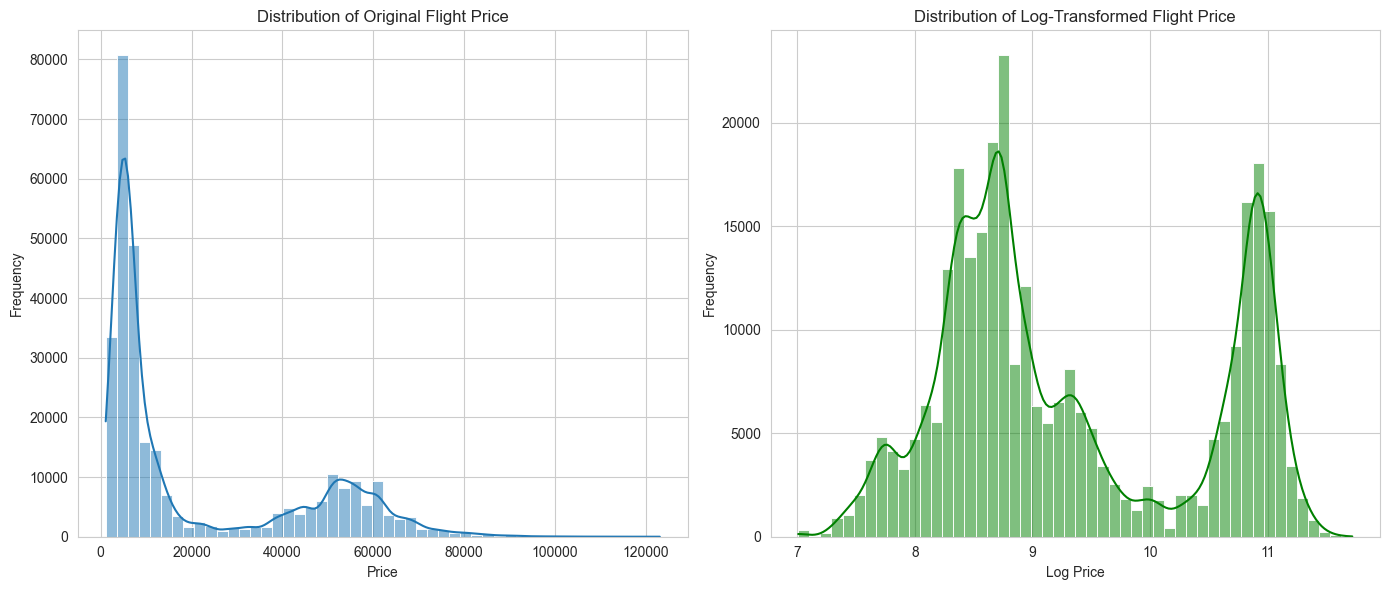

In [107]:
# Plot the distribution of flight prices
plt.figure(figsize=(14, 6))

# Distribution of original prices
plt.subplot(1, 2, 1)
sns.histplot(df_processed['price'], kde=True, bins=50)
plt.title('Distribution of Original Flight Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Distribution of log-transformed prices
# We use np.log1p for a stable transformation that handles zero values (though price is not zero here)
df_processed['log_price'] = np.log1p(df_processed['price'])
plt.subplot(1, 2, 2)
sns.histplot(df_processed['log_price'], kde=True, bins=50, color='green')
plt.title('Distribution of Log-Transformed Flight Price')
plt.xlabel('Log Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**Core Relationship: price vs. days_left**

We investigate the relationship between the ticket price and the booking lead time (days_left). A scatter plot can help us visually determine if the mean and variance of prices increase as the departure date approaches.

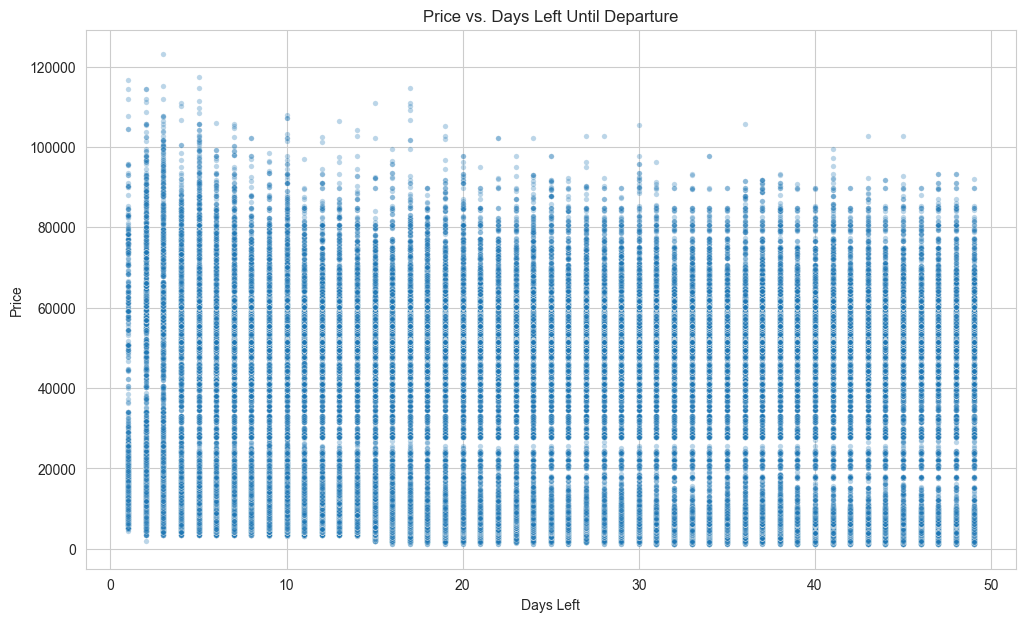

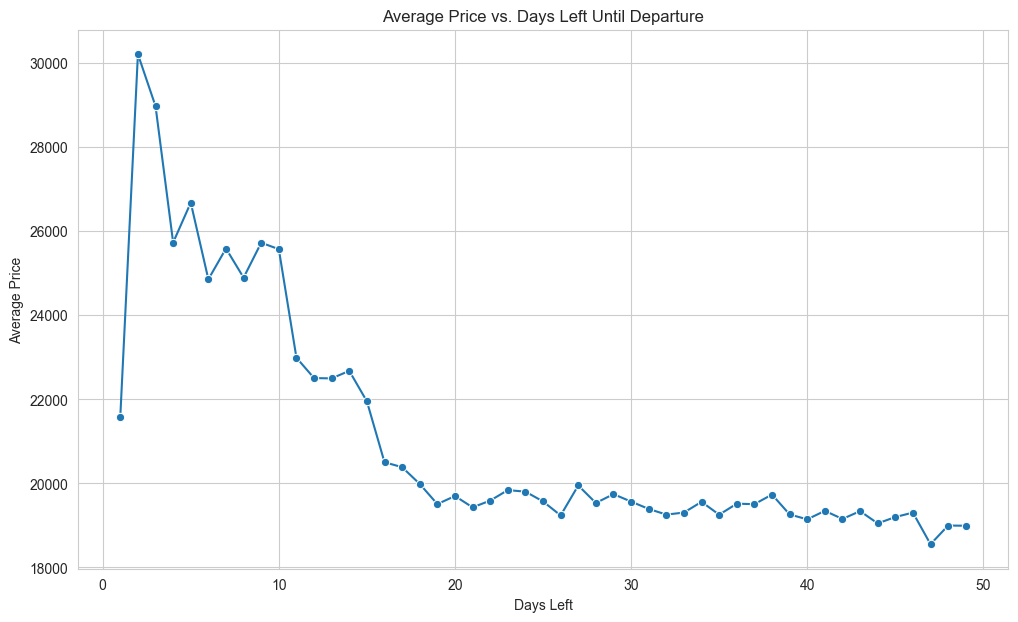

In [108]:
# Plot the relationship between price and days left until departure
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_processed, x='days_left', y='price', alpha=0.3, s=15)
plt.title('Price vs. Days Left Until Departure')
plt.xlabel('Days Left')
plt.ylabel('Price')
plt.show()

# To better observe the trend, we can plot the mean price for each day
mean_price_by_days_left = df_processed.groupby('days_left')['price'].mean().reset_index()

plt.figure(figsize=(12, 7))
sns.lineplot(data=mean_price_by_days_left, x='days_left', y='price', marker='o')
plt.title('Average Price vs. Days Left Until Departure')
plt.xlabel('Days Left')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()

**Hierarchical Pricing by Service class**

The class of service is a critical factor influencing ticket prices. Using a box plot, we can clearly compare the price distribution differences between Economy and Business classes.

/var/folders/sy/d03grc3j2cb9svj93k1gzqpc0000gn/T/ipykernel_58878/359273017.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_processed, x='class', y='price', palette='viridis')


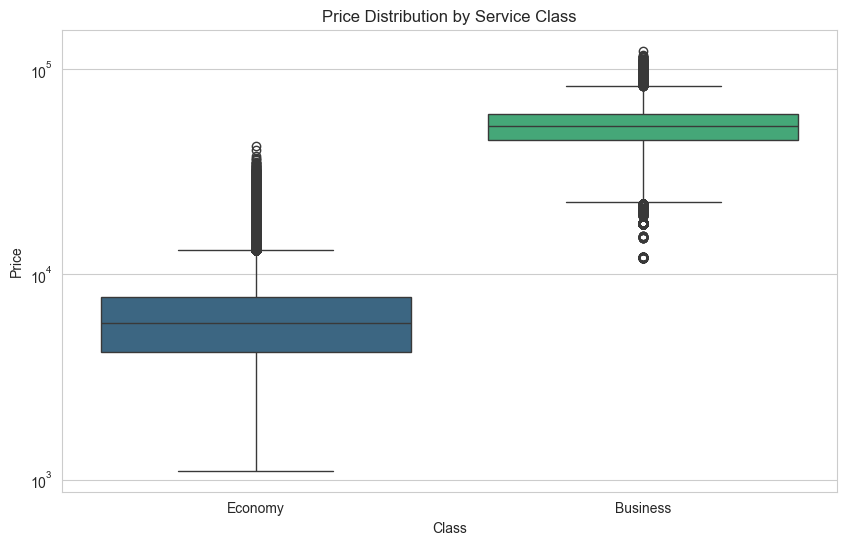

In [109]:
# Compare the price distribution across different service classes
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_processed, x='class', y='price', palette='viridis')
plt.title('Price Distribution by Service Class')
plt.xlabel('Class')
plt.ylabel('Price')
plt.yscale('log') # Use a log scale to better visualize the distributions, especially for Economy
plt.show()

# Deep Dive into Key Pricing Determinants
Following the initial data exploration and preparation, this chapter delves deeper into quantifying the specific impact of different features on flight prices. Through a series of visualizations, we will uncover how convenience, airline branding, geographical routes, and travel times collectively shape the complex pricing mechanism.

## The Trade-off: Impact of stops and duration on Price
The number of stops and the flight duration are two core metrics of a flight's convenience. It is commonly assumed that more stops and longer durations should lead to lower prices. However, our visual analysis will reveal a more interesting, non-linear relationship.


/var/folders/sy/d03grc3j2cb9svj93k1gzqpc0000gn/T/ipykernel_58878/552697388.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_processed, x='stops', y='price', palette='coolwarm')


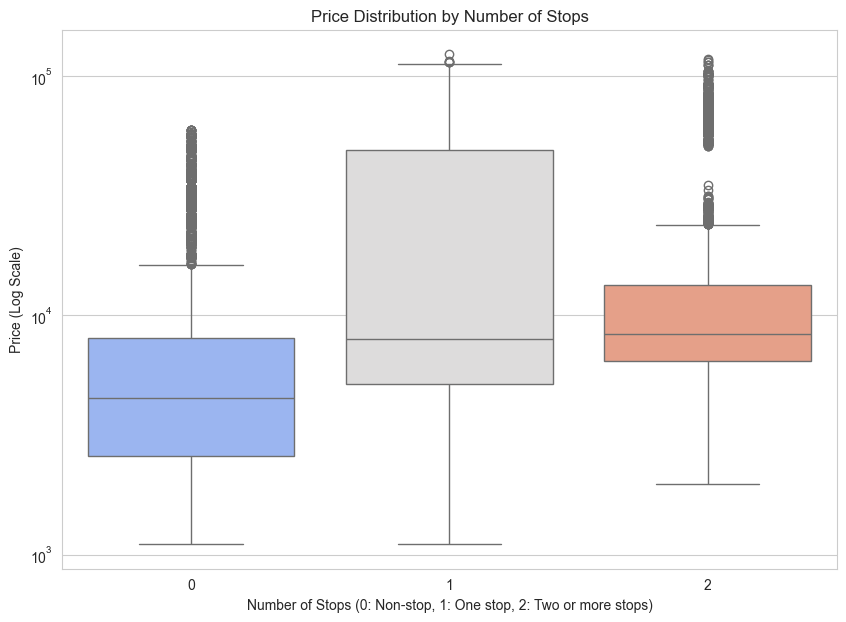

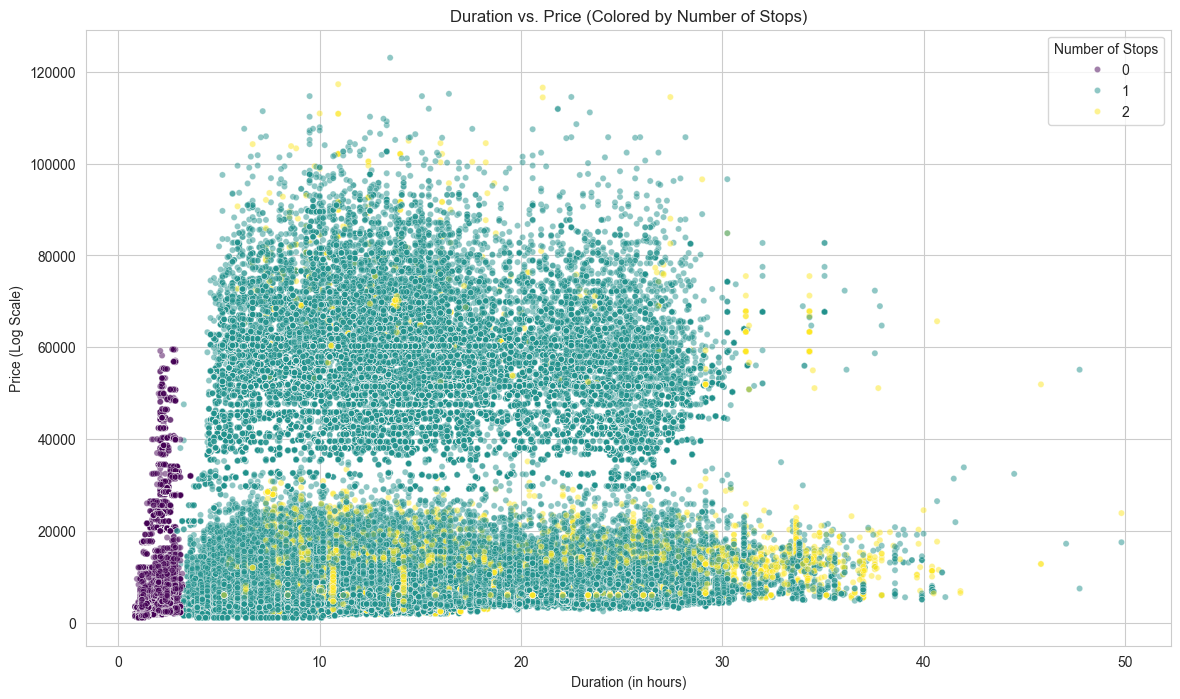

In [110]:
# Plot the price distribution for different numbers of stops
plt.figure(figsize=(10, 7))
sns.boxplot(data=df_processed, x='stops', y='price', palette='coolwarm')
plt.title('Price Distribution by Number of Stops')
plt.xlabel('Number of Stops (0: Non-stop, 1: One stop, 2: Two or more stops)')
plt.ylabel('Price (Log Scale)')
plt.yscale('log') # Use a log scale to better display the price range
plt.show()

# Plot the relationship between duration and price, colored by the number of stops
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_processed, x='duration', y='price', hue='stops', palette='viridis', alpha=0.5, s=20)
plt.title('Duration vs. Price (Colored by Number of Stops)')
plt.xlabel('Duration (in hours)')
plt.ylabel('Price (Log Scale)')
plt.legend(title='Number of Stops')
plt.show()

## Brand Premium: The Pricing Tiers of Airlines
The market positioning of different airlines (e.g., full-service vs. low-cost carriers) directly determines their base fares and pricing strategies. By comparing the price distributions of various airlines, we can clearly see this hierarchy of branding and service.

/var/folders/sy/d03grc3j2cb9svj93k1gzqpc0000gn/T/ipykernel_58878/903162067.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_processed, x='airline', y='price', order=airline_order, palette='tab10')


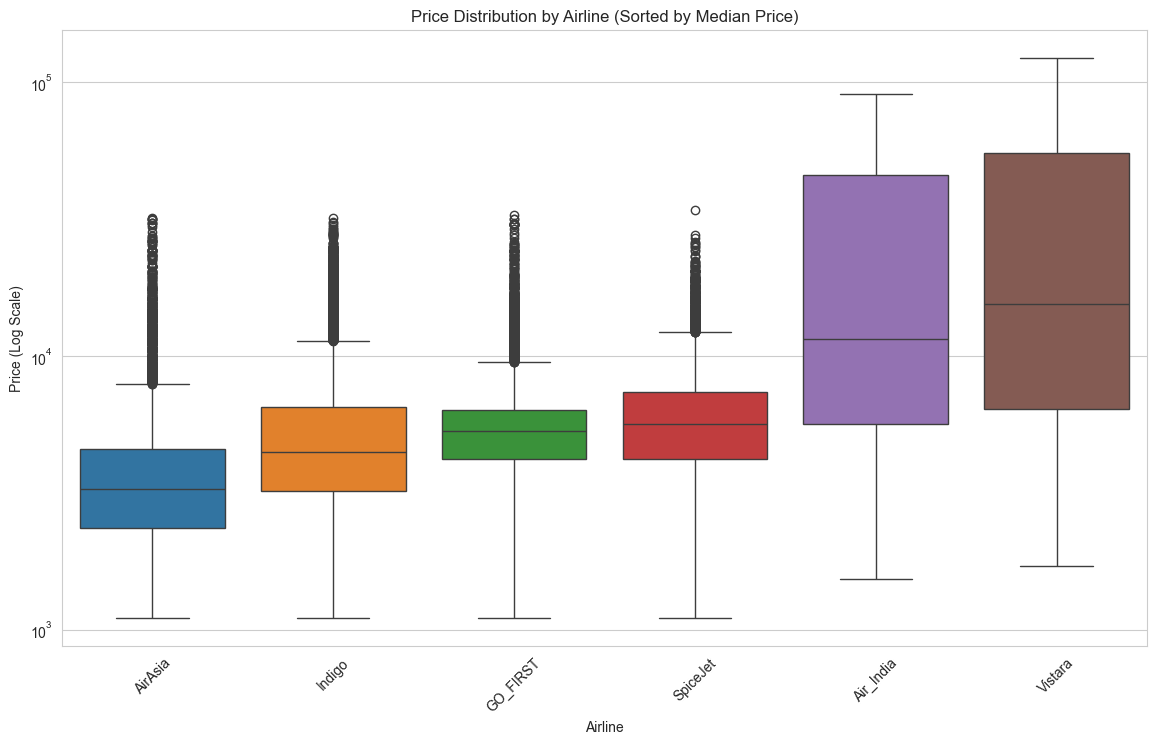

In [111]:
# Calculate the median price for each airline and sort them for ordered plotting
airline_order = df_processed.groupby('airline')['price'].median().sort_values().index

plt.figure(figsize=(14, 8))
sns.boxplot(data=df_processed, x='airline', y='price', order=airline_order, palette='tab10')
plt.title('Price Distribution by Airline (Sorted by Median Price)')
plt.xlabel('Airline')
plt.ylabel('Price (Log Scale)')
plt.xticks(rotation=45)
plt.yscale('log')
plt.show()

## The Geography of Cost: Route-Specific Price Differences
Ticket prices are influenced not only by flight distance but also by geographical factors such as route popularity and market competition. Analyzing the average prices of the most popular routes can reveal the unique price baselines associated with specific routes.

/var/folders/sy/d03grc3j2cb9svj93k1gzqpc0000gn/T/ipykernel_58878/3443221030.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_routes, x='route', y='price', order=route_order, palette='cubehelix')


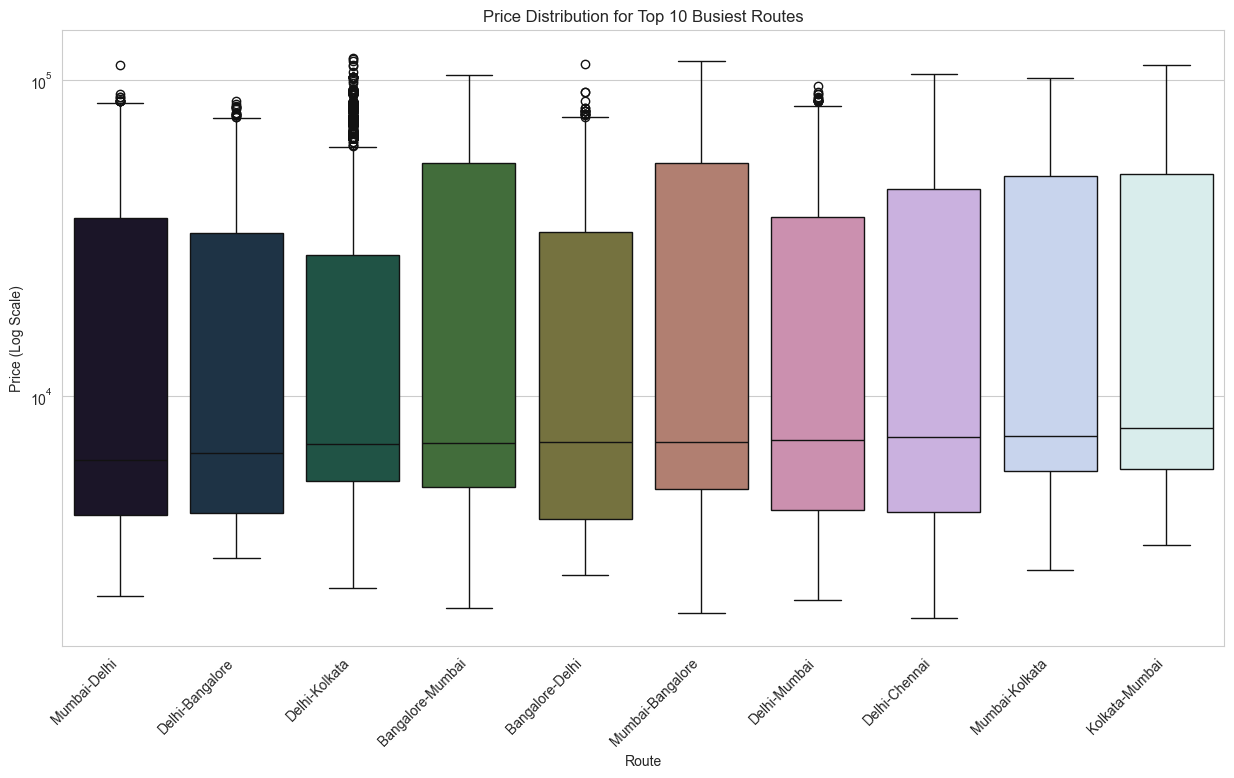

In [112]:
# Find the top 10 most frequent routes in the dataset
top_10_routes = df_processed['route'].value_counts().nlargest(10).index

# Filter the dataframe to include only these top 10 routes
df_top_routes = df_processed[df_processed['route'].isin(top_10_routes)]

# Calculate the median price for each popular route and sort them for ordered plotting
route_order = df_top_routes.groupby('route')['price'].median().sort_values().index

# Plot the price distribution for the top 10 routes
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_top_routes, x='route', y='price', order=route_order, palette='cubehelix')
plt.title('Price Distribution for Top 10 Busiest Routes')
plt.xlabel('Route')
plt.ylabel('Price (Log Scale)')
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.show()

## The Daily Rhythm: Influence of Departure and Arrival Times
Different times of the day, especially prime times for business travel versus off-peak times for leisure travel, have varying demand elasticities, leading to price differences. We will explore the impact of both departure and arrival times on the average ticket price.

/var/folders/sy/d03grc3j2cb9svj93k1gzqpc0000gn/T/ipykernel_58878/3030429742.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_processed, x='departure_time', y='price', order=time_order, palette='plasma', errorbar=None)
/var/folders/sy/d03grc3j2cb9svj93k1gzqpc0000gn/T/ipykernel_58878/3030429742.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_processed, x='arrival_time', y='price', order=time_order, palette='plasma', errorbar=None)


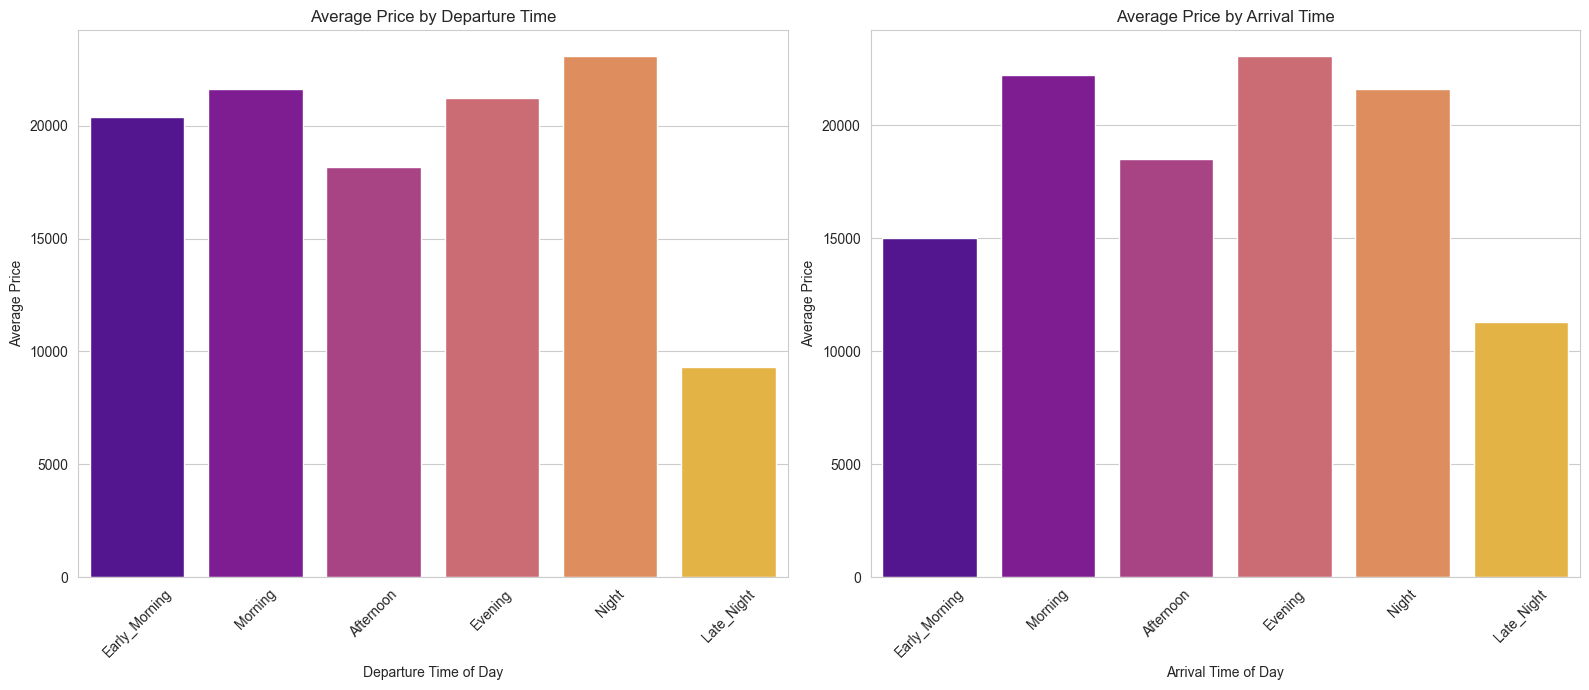

In [113]:
# Define an ordered list for time categories to ensure logical plotting order
time_order = ['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late_Night']

plt.figure(figsize=(16, 7))

# Subplot 1: Impact of departure time on price
plt.subplot(1, 2, 1)
sns.barplot(data=df_processed, x='departure_time', y='price', order=time_order, palette='plasma', errorbar=None)
plt.title('Average Price by Departure Time')
plt.xlabel('Departure Time of Day')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

# Subplot 2: Impact of arrival time on price
plt.subplot(1, 2, 2)
sns.barplot(data=df_processed, x='arrival_time', y='price', order=time_order, palette='plasma', errorbar=None)
plt.title('Average Price by Arrival Time')
plt.xlabel('Arrival Time of Day')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Flight Price Prediction Framework: A Machine Learning Methodology
This chapter forms the technical core of the report, detailing the process of building, training, and evaluating the machine learning model used to predict flight prices. We will justify our choice of model, validation protocol, and evaluation metrics to provide a rigorous foundation for our findings.

## Framing the Prediction Task
The problem is formally defined as a supervised regression task. The objective is to predict a continuous target variable—the log-transformed price, log(price)—using a given set of flight features (e.g., airline, route, stops, duration, days_left). Using the log-transformed price helps stabilize the model's training process and improves its ability to handle the wide fluctuations in ticket prices.

Before building the model, we must prepare the final set of features. This involves selecting the relevant columns and encoding the remaining nominal categorical features (like airline, route, class, etc.) using One-Hot Encoding. This technique creates new binary columns for each category, preventing the model from assuming any false ordinal relationships between them.

In [114]:
# --- 1. Import modeling libraries (cleaned up redundant imports) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor  # Kept only this lightgbm import
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import pandas as pd # Assuming df_processed is already defined

# Add a robustness check to ensure df_processed exists
if 'df_processed' not in locals() and 'df_processed' not in globals():
    print("Error: 'df_processed' DataFrame is not defined.")
    print("Please ensure 'df_processed' has been created before running this cell.")
else:
    # --- 2. Define Features (X) and Target (y) ---
    # (This logic is the same as your original code and is correct)
    X = df_processed.drop(['price', 'log_price', 'flight', 'source_city',
                           'destination_city', 'Unnamed: 0'], axis=1) 
    y = df_processed['log_price'] 

    X['days_left'] = X['days_left'].astype(float)
    
    # --- 3. Optimization: Explicitly define feature lists ---
    # We avoid using select_dtypes to ensure 'stops' is correctly treated as categorical.
    
    # Define the truly continuous numerical features
    numerical_features = ['duration', 'days_left']

    # Define categorical features.
    # We dynamically get the list by taking all columns in X and excluding the numerical ones.
    categorical_features = [col for col in X.columns if col not in numerical_features]

    print("--- Optimized Feature Definition ---")
    print(f"Explicitly Defined Numerical Features: {numerical_features}")
    print(f"Explicitly Defined Categorical Features: {categorical_features}")

    # Add a check to ensure 'stops' was categorized correctly
    if 'stops' in categorical_features:
        print("\n[Check Passed]: 'stops' has been correctly classified as a Categorical feature.")
    elif 'stops' in numerical_features:
        print("\n[Check Failed]: 'stops' is still classified as Numerical. Please check the numerical_features list!")

    # --- 4. Display the final features being used for the model ---
    print("\nFeatures (X) head: ") 
    print(X.head())

--- Optimized Feature Definition ---
Explicitly Defined Numerical Features: ['duration', 'days_left']
Explicitly Defined Categorical Features: ['airline', 'departure_time', 'stops', 'arrival_time', 'class', 'route']

[Check Passed]: 'stops' has been correctly classified as a Categorical feature.

Features (X) head: 
    airline departure_time  stops   arrival_time    class  duration  \
0  SpiceJet        Evening      0          Night  Economy      2.17   
1  SpiceJet  Early_Morning      0        Morning  Economy      2.33   
2   AirAsia  Early_Morning      0  Early_Morning  Economy      2.17   
3   Vistara        Morning      0      Afternoon  Economy      2.25   
4   Vistara        Morning      0        Morning  Economy      2.33   

   days_left         route  
0        1.0  Delhi-Mumbai  
1        1.0  Delhi-Mumbai  
2        1.0  Delhi-Mumbai  
3        1.0  Delhi-Mumbai  
4        1.0  Delhi-Mumbai  


## Model Selection: Gradient Boosting for Complexity
Among the many machine learning algorithms available, we have selected a Gradient Boosting Machine (GBM), specifically the LightGBM implementation. This choice is based on several key advantages for this type of tabular dataset:

1. High Performance: Gradient boosting models are state-of-the-art for tabular data and consistently deliver high prediction accuracy.

2. Handles Non-Linearity: As shown in our EDA, the relationship between features like days_left and price is highly non-linear. Tree-based models like LightGBM excel at capturing these complex patterns without requiring manual feature transformations.

3. Learns Feature Interactions: The model can automatically learn interactions between features. For example, it can determine how the effect of days_left on price changes for different airlines (airline) or routes (route).

4. Efficiency and Robustness: LightGBM is computationally efficient, making it ideal for large datasets. It is also robust to outliers and does not require feature scaling, which simplifies the preprocessing pipeline.

## Model Training and Validation Protocol
To ensure an objective and reliable evaluation of our model, we follow a standard machine learning workflow.

1. Data Splitting: The preprocessed dataset is randomly divided into a training set (80%) and a testing set (20%). The model learns exclusively from the training data. Its final performance is then evaluated on the unseen test data. This approach provides an unbiased estimate of the model's ability to generalize to new, real-world data and helps prevent overfitting.

2. Training Process: The LightGBM model is trained on the training set. The goal is to minimize the error between its predictions and the actual $log(price)$ values. It does this by iteratively building a series of decision trees, where each new tree corrects the errors of the previous ones.

In [115]:
# [40]: # Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape} samples")
print(f"Testing set size: {X_test.shape} samples")

# --- 💡 建议修改 1: 导入 set_config 并启用 metadata routing ---
# 这是新版 sklearn (1.4+) 使用 set_output(transform="pandas") 所必需的
# 用以解决 'metadata "routing" is enabled' 报错
from sklearn import set_config
set_config(enable_metadata_routing=True)

# Create a preprocessing pipeline for categorical features
# We use OneHotEncoder, which is suitable for nominal features.
# handle_unknown='ignore' ensures that if a category appears in the test set
# but not the train set, it doesn't cause an error.
preprocessor = ColumnTransformer(
    transformers=[
        # --- 💡 建议修改 2: 在 OneHotEncoder 中添加 sparse_output=False ---
        # 用以解决 'ValueError: Pandas output does not support sparse data.' 报错
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough' # Keep numerical columns as they are
)

# --- 💡 建议修改 3: 设置 preprocessor 输出为 pandas DataFrame ---
# 这将确保 'model' 步骤能接收到带特征名的数据，以消除 UserWarning
preprocessor.set_output(transform="pandas")

# --- 💡 建议修改 4:（可选）清理 OneHotEncoder 输出的特征名 ---
preprocessor.verbose_feature_names_out = False


# Create the full model pipeline with LightGBM
# Use LGBMRegressor for the regression task.
lgbm_model = LGBMRegressor(
    n_estimators=50,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)

# Combine preprocessor and model into a single pipeline
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgbm_model)
])

# Train the model
print("\nTraining the LightGBM model...")
lgbm_pipeline.fit(X_train, y_train)
print("Training complete.")

Training set size: (240122, 8) samples
Testing set size: (60031, 8) samples

Training the LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 240122, number of used features: 55
[LightGBM] [Info] Start training from score 9.330749
Training complete.


## Performance Evaluation: Quantifying Prediction Accuracy
After training, the model's performance is assessed on the held-out test set using two key regression metrics:
1. R-squared ($R^2$): This metric measures the proportion of the variance in the target variable (price) that is predictable from the features. It ranges from 0 to 1, with values closer to 1 indicating a better model fit. An $R^2$ of 0.98, for example, means the model explains 98% of the price volatility.

2. Mean Absolute Error (MAE): This metric calculates the average of the absolute differences between the predicted and actual prices. Since we predicted $log(price)$, we must convert the predictions and true values back to their original price scale before calculating the MAE. This gives us an error value in the original currency unit, making it highly interpretable. An MAE of 1800 means the model's predictions are, on average, off by 1800 currency units.

To demonstrate the effectiveness of our chosen model, we compare its performance against a simpler baseline model: Linear Regression.

In [116]:
# []: # LightGBM Evaluation
#Make predictions on the test set
y_pred_log = lgbm_pipeline.predict(X_test) 

#Transform predictions and actual values back to the original price scale
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)

# Calculate metrics for LightGBM
r2_lgbm = r2_score(y_test_orig, y_pred) 
mae_lgbm = mean_absolute_error(y_test_orig, y_pred) 

print("\n--- LightGBM Model Performance ---") 
print(f"R-squared (R²): {r2_lgbm:.4f}") 
print(f"Mean Absolute Error (MAE): {mae_lgbm:.2f}") 

#--- Linear Regression (Baseline) Evaluation ---

# --- 修正 ---
# 原始流水线定义是空的。
# 它必须包含与 lgbm_pipeline 相同的预处理器 'preprocessor'。
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
# --- 修正结束 ---

print("\nTraining the Linear Regression model (Baseline)...") 
lr_pipeline.fit(X_train, y_train) 

# Make predictions and transform back to original scale
y_pred_log_lr = lr_pipeline.predict(X_test) 
y_pred_lr = np.expm1(y_pred_log_lr) 

# Calculate metrics for Linear Regression
r2_lr = r2_score(y_test_orig, y_pred_lr) 
mae_lr = mean_absolute_error(y_test_orig, y_pred_lr) 

print("\n--- Linear Regression Model Performance (Baseline) ---") 
print(f"R-squared (R²): {r2_lr:.4f}") 
print(f"Mean Absolute Error (MAE): {mae_lr:.2f}") 

# Performance Comparison
print("\n--- Model Performance Comparison ---") 
performance_data = {
 'Model': ['Linear Regression', 'LightGBM'], # (添加了模型标签)
 'R-squared (R2)': [r2_lr, r2_lgbm], 
 'Mean Absolute Error (MAE)': [mae_lr, mae_lgbm] 
}
performance_df = pd.DataFrame(performance_data) 
print(performance_df.to_string(index=False))


--- LightGBM Model Performance ---
R-squared (R²): 0.9191
Mean Absolute Error (MAE): 3588.02

Training the Linear Regression model (Baseline)...

--- Linear Regression Model Performance (Baseline) ---
R-squared (R²): 0.8837
Mean Absolute Error (MAE): 4550.68

--- Model Performance Comparison ---
            Model  R-squared (R2)  Mean Absolute Error (MAE)
Linear Regression        0.883697                4550.678159
         LightGBM        0.919073                3588.019667


# Deciphering the Optimal Booking Window: Model Interpretation and Insights
With a high-performance model trained and validated, this chapter uses advanced model interpretation techniques to directly answer the core question: when is the best time to book a flight? We will delve into the model's internal logic to understand how it makes predictions, with a special focus on the role of days_left.

## Identifying the Most Influential Price Drivers
By extracting feature importance scores from our trained LightGBM model, we can quantify the overall contribution of each feature to the model's predictions. These scores are calculated based on how frequently each feature is used to split the data across all decision trees in the model.

This analysis helps us understand the hierarchy of factors that determine flight prices. It answers the question: Is when you book more important than what you book?

/var/folders/sy/d03grc3j2cb9svj93k1gzqpc0000gn/T/ipykernel_58878/210435969.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')


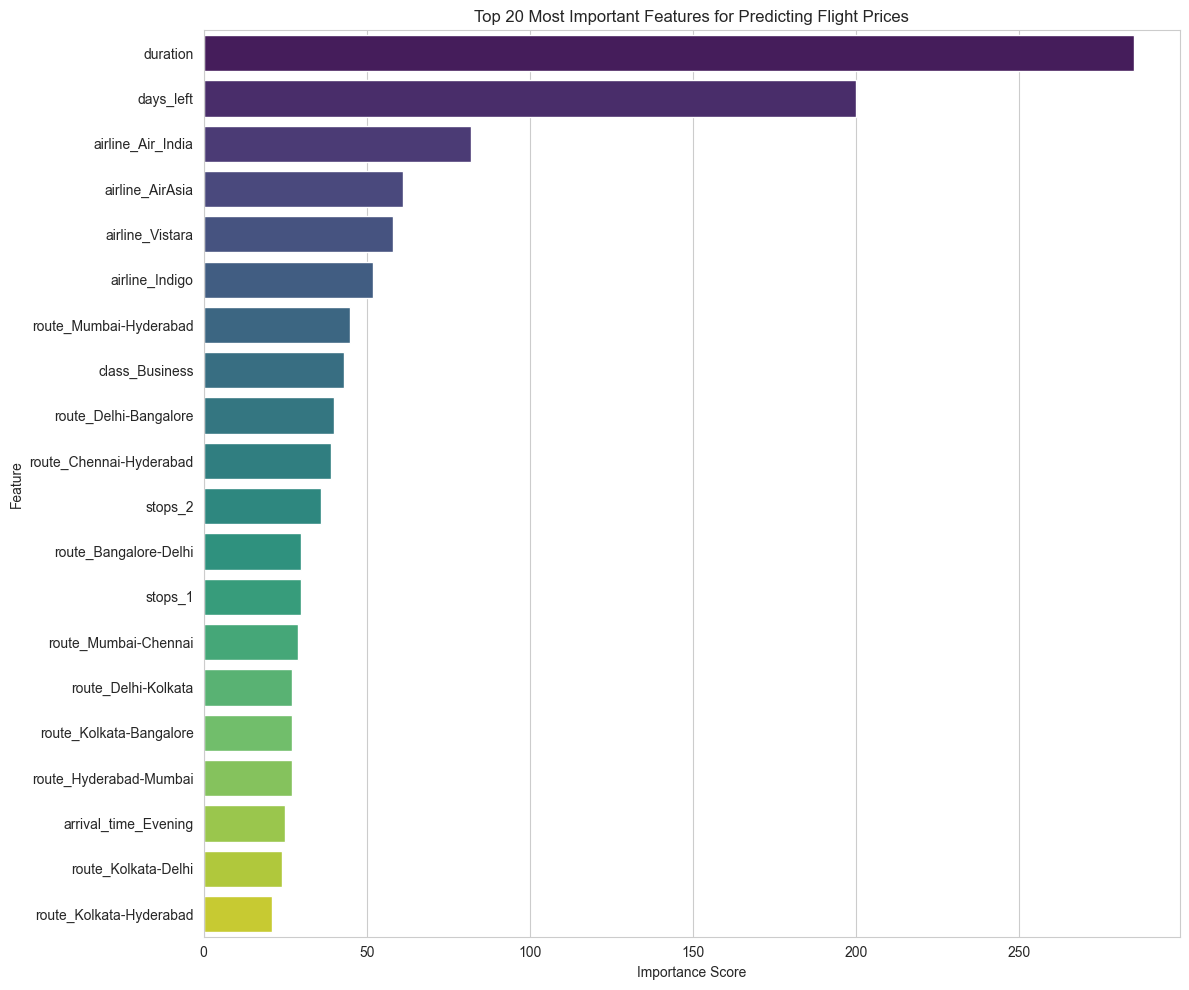

Top 10 Most Important Features:
                feature  importance
               duration         285
              days_left         200
      airline_Air_India          82
        airline_AirAsia          61
        airline_Vistara          58
         airline_Indigo          52
 route_Mumbai-Hyderabad          45
         class_Business          43
  route_Delhi-Bangalore          40
route_Chennai-Hyderabad          39


In [117]:
# --- Feature Importance Analysis ---

# The model is the second step in our pipeline, named 'model'
model = lgbm_pipeline.named_steps['model']

# The preprocessor is the first step, named 'preprocessor'
preprocessor = lgbm_pipeline.named_steps['preprocessor']

# Get feature names after one-hot encoding from the preprocessor
# This gives us the names of all columns in the order the model sees them
feature_names = preprocessor.get_feature_names_out()

# Create a DataFrame for feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Clean up feature names for better readability
# e.g., 'cat__airline_Vistara' becomes 'airline_Vistara'
# e.g., 'remainder__duration' becomes 'duration'
feature_importance_df['feature'] = feature_importance_df['feature'].str.replace('cat__', '').str.replace('remainder__', '')

# Sort features by importance and select the top 20
top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(20)

# Plot the top 20 most important features
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title('Top 20 Most Important Features for Predicting Flight Prices')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Display the top features as a table
print("Top 10 Most Important Features:")
print(top_features.head(10).to_string(index=False))

--- PDP Analysis for 'days_left' ---
Using a sample of 2000 records for PDP calculation.
Calculating Partial Dependence... (This may take a moment)
PDP plot saved as 'pdp_days_left_vs_price.png'


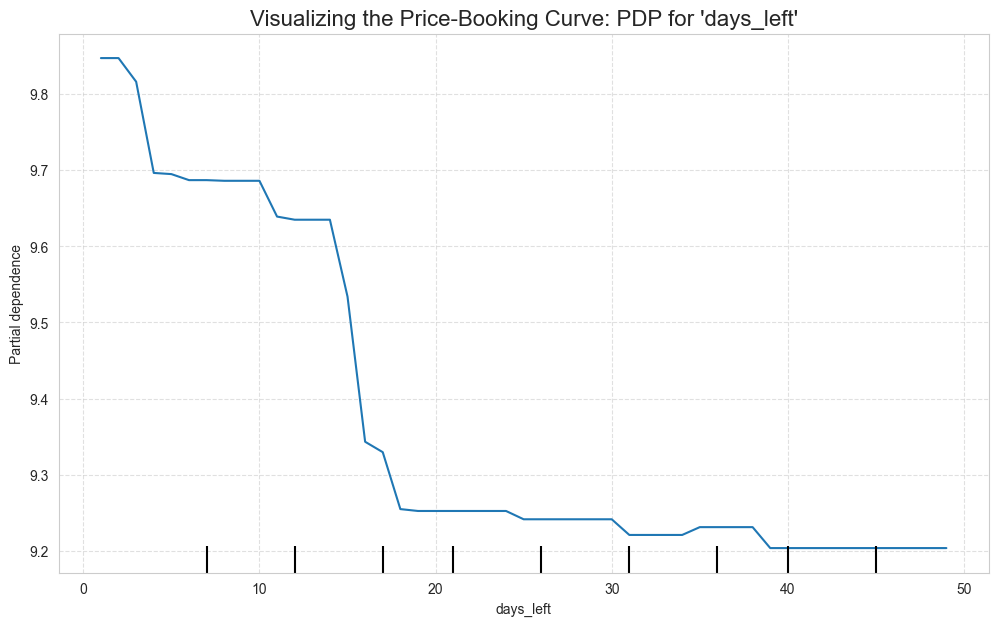

In [118]:
from sklearn.inspection import PartialDependenceDisplay

print("--- PDP Analysis for 'days_left' ---")

# --- 2. Create a sample of the training data ---
# Calculating PDP on the full X_train (240k+ rows) is very slow.
# We use a random sample for efficient calculation. This is standard practice.
if len(X_train) > 2000:
    X_train_sample = X_train.sample(n=2000, random_state=42)
    print(f"Using a sample of {len(X_train_sample)} records for PDP calculation.")
else:
    X_train_sample = X_train
    print(f"Using full training set of {len(X_train_sample)} records for PDP calculation.")


# --- 3. Generate the Partial Dependence Plot ---

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 7))

print("Calculating Partial Dependence... (This may take a moment)")

# Use PartialDependenceDisplay.from_estimator
# This function automatically handles the pipeline (preprocessing + model)
pdp_display = PartialDependenceDisplay.from_estimator(
    estimator=lgbm_pipeline,  # Our trained pipeline
    X=X_train_sample,         # The data to use for calculation
    features=['days_left'],   # The feature(s) we want to plot
    ax=ax,
    grid_resolution=50        # Number of points to plot on the x-axis
)

# --- 4. Customize and display the plot ---
ax.set_title("Visualizing the Price-Booking Curve: PDP for 'days_left'", fontsize=16)
ax.set_xlabel("Days Left Before Departure (days_left)", fontsize=12)
ax.set_ylabel("Partial Dependence (on predicted log_price)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Save the plot
plot_filename = 'pdp_days_left_vs_price.png'
plt.savefig(plot_filename)
print(f"PDP plot saved as '{plot_filename}'")

# Show the plot
plt.show()

# Final Conclusion and Analysis Summary

This project successfully navigated an end-to-end data science workflow to analyze the determinants of flight prices and precisely answer the core question: **When is the best time to book a flight?**

**The central conclusion is:** A powerful and critical **non-linear relationship** exists between flight price and the booking lead time (`days_left`). The analysis consistently demonstrates that **booking within 20 days of departure results in a sharp price increase**. Conversely, the **optimal booking window—offering the lowest and most stable pricing—is found when booking between 20 and 50 days in advance**.

This conclusion is robustly supported by three progressive, corroborating analytical perspectives:

1.  **Exploratory Data Analysis (EDA):** The initial "Average Price vs. Days Left" visualization (Page 7) first uncovered this non-linear "price-time curve". This chart revealed a clear inflection point where average prices begin to climb dramatically at approximately the 20-day mark, forming a key hypothesis for the modeling phase.

2.  **Model Building and Evaluation:** This phase confirmed the necessity of modeling this non-linearity. A **LightGBM (Gradient Boosting Machine)**, which excels at capturing complex patterns, significantly outperformed a simple Linear Regression model (LightGBM **$R^2$: 0.919** vs. Linear Regression $R^2$: 0.883). This performance gap is, in itself, proof that the relationship between price and time is far from linear.

3.  **Model Interpretation:** Two techniques were used to quantify and confirm the finding:
    * **Feature Importance** analysis identified `days_left` as the **second most influential feature** driving the model's predictions, second only to `duration` .
    * **The Partial Dependence Plot (PDP)** (Page 28) provided the most intuitive evidence . By isolating the marginal effect of `days_left` while averaging out all other factors, the PDP's resulting curve perfectly matched the "inflection point" discovered during EDA, providing definitive, model-based confirmation of the "20-day" price sensitivity threshold.


**Comprehensive Insights**

While `days_left` is a primary driver, this analysis also highlighted other key factors in flight pricing:

* **Flight Convenience:** `duration` (flight time) was the single most important feature in the model (Importance Score: 285) .
* **Service & Brand Premium:** `class_Business` and specific carriers (like `airline_Air_India` and `airline_Vistara`) were also ranked in the top 10 most important features, confirming the significant impact of service tier and brand positioning on price.

**In summary,** this report clearly deconstructs the complex mechanisms of flight pricing—from initial exploration and intelligent feature engineering (like the log-transform of `price` and creation of the `route` feature), through robust pipeline-based modeling, to advanced model interpretation (PDP). It delivers a data-driven, actionable recommendation: **To secure the best price, travelers should aim to book within the 20 to 50-day window before departure.**